<p style="font-family: 'Meiryo UI'; font-size: 32px; padding: 25px; text-align: center; color: #ffffff; border-radius: 25px;  font-weight: bold; background-color: #005080;">📚 Kaggle Competition: Academic Success 🤓</p>

This is part of my current solution for the Kaggle competition [Classification with an Academic Success Dataset](https://www.kaggle.com/competitions/playground-series-s4e6/overview).

In this notebook, I will present data preprocessing, feature engineering, model selection, and evaluation used in this challenge. The dataset used in this competition is synthetically generated from real-world data, allowing us to work with interesting datasets while ensuring test labels are not publicly available.


<p style="font-family: 'Meiryo UI'; font-size: 30px; padding: 12px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #007040;">📚 Libraries</p>

In [1]:

%%time
%matplotlib inline

import os
import json
import optuna

import numpy as np
import pandas as pd
import seaborn as sns

import xgboost as xgb
import catboost as cb
import lightgbm as lgbm

import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from scipy import stats
from sklearn.svm import OneClassSVM

clear_output()

CPU times: total: 672 ms
Wall time: 2.44 s


<p style="font-family: 'Meiryo UI'; font-size: 30px; padding: 12px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #007040;">📖 Loading the Dataset</p>

In [2]:
RANDOM_SEED = 101

PATH_TRAIN = 'playground-series-s4e6/train.csv'
PATH_TEST = 'playground-series-s4e6/test.csv'
PATH_SAMPLE = 'playground-series-s4e6/sample_submission.csv'

In [3]:
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

<p style="font-family: 'Meiryo UI'; font-size: 30px; padding: 12px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #007040;">🔎 Quick Overview
</p>


- There are no missing values
- There are no duplicates

In [4]:
df_train.isnull().sum()

id                                                0
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship 

In [5]:
duplicates = df_train[df_train.duplicated()]
duplicates

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target


In [6]:
print(f"There are {df_train.shape[0]} instances in the training dataset")
print(f"There are {df_test.shape[0]} instances in the test dataset")

There are 76518 instances in the training dataset
There are 51012 instances in the test dataset


<p style="font-family: 'Meiryo UI'; font-size: 30px; padding: 12px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #007040;">🕵️ Exploratory Data Analysis</p>


- The Graduate category has the highest percentage, indicating that it may be easier to understand the factors contributing to successful outcomes.
- The dataset is imbalanced, which can significantly affect model performance metrics like accuracy in real-world scenarios.



**IMPORTANT OBSERVATION**:

- While metrics such as the F1-Score could provide a better understanding of model performance and issues due to this imbalance, the competition evaluates models strictly based on standard accuracy. Therefore, we will use accuracy as the primary metric for this analysis.

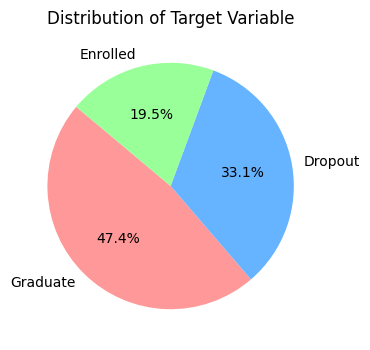

In [7]:
target_distribution = df_train['Target'].value_counts()

plt.figure(figsize=(4, 4))

plt.pie(
    target_distribution,
    labels=target_distribution.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['#ff9999','#66b3ff','#99ff99']
)

plt.title('Distribution of Target Variable')
plt.show()

- Category 1 heavily dominates this feature. By looking to the description of the [original dataset](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success), this means that most students are single.
- There is a consistency of the distribution across the train and test sets.
- Categories 3 and 6, e.g., Widower and Legally Separated, have significantly fewer instances.

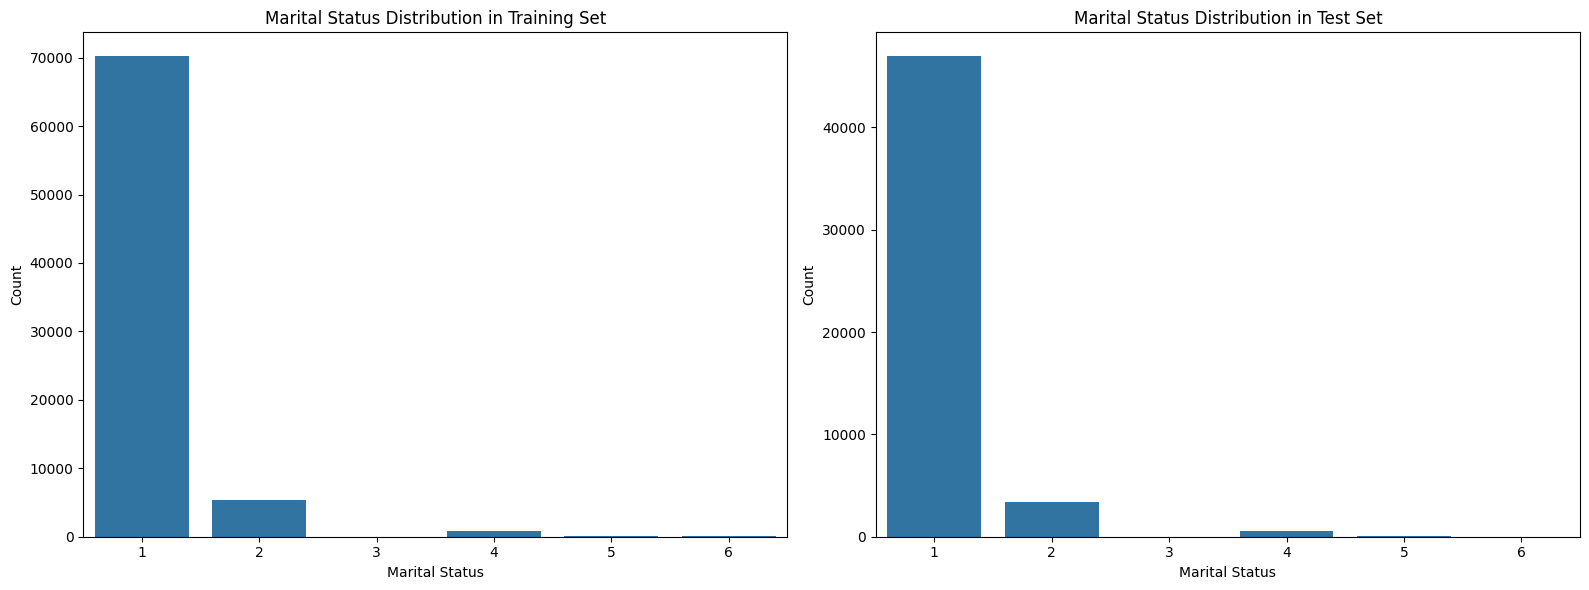

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.countplot(data=df_train, x='Marital status', ax=axes[0])

axes[0].set_title('Marital Status Distribution in Training Set')
axes[0].set_xlabel('Marital Status')
axes[0].set_ylabel('Count')

sns.countplot(data=df_test, x='Marital status', ax=axes[1])

axes[1].set_title('Marital Status Distribution in Test Set')
axes[1].set_xlabel('Marital Status')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

- Bimodal Distribution: The histogram with a KDE plot shows a bimodal distribution in the previous qualification grades, with two distinct peaks. This indicates that there are two common grade ranges among students.

- Concentration of Grades: Most grades are concentrated around the peaks, with fewer students having grades in the lower and higher ranges.
Potential for Binning: 

- The distinct peaks suggest that binning the grades into categories (e.g., low, medium, high) might be beneficial for simplifying the analysis and model training.

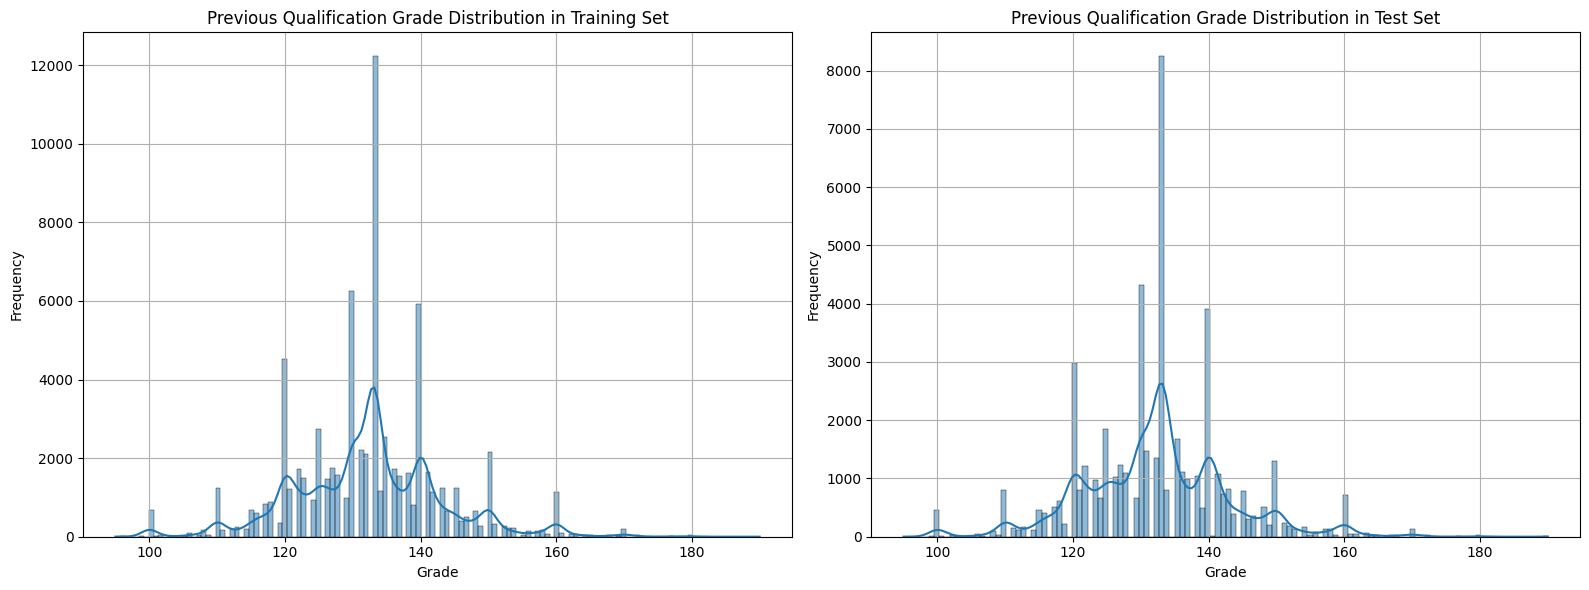

In [9]:
# Create a figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for df_train
sns.histplot(data=df_train, x='Previous qualification (grade)', kde=True, ax=axes[0])
axes[0].set_title('Previous Qualification Grade Distribution in Training Set')
axes[0].set_xlabel('Grade')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot for df_test
sns.histplot(data=df_test, x='Previous qualification (grade)', kde=True, ax=axes[1])
axes[1].set_title('Previous Qualification Grade Distribution in Test Set')
axes[1].set_xlabel('Grade')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

- Preference for Daytime Attendance: The bar chart shows a clear preference for daytime attendance over evening attendance, with a significantly higher count of students attending daytime classes.

- Potential Implications: This skew may reflect preferences or constraints, such as work schedules or institutional policies.

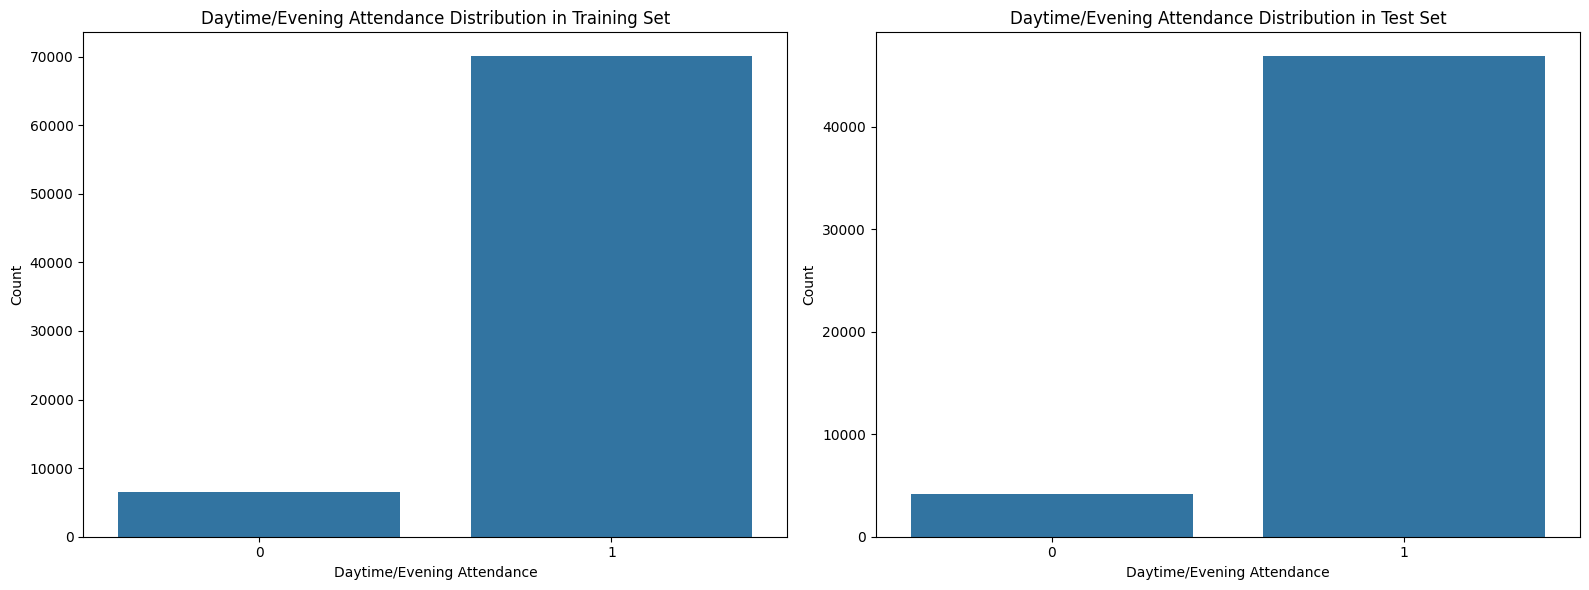

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.countplot(data=df_train, x='Daytime/evening attendance', ax=axes[0])
axes[0].set_title('Daytime/Evening Attendance Distribution in Training Set')
axes[0].set_xlabel('Daytime/Evening Attendance')
axes[0].set_ylabel('Count')

sns.countplot(data=df_test, x='Daytime/evening attendance', ax=axes[1])
axes[1].set_title('Daytime/Evening Attendance Distribution in Test Set')
axes[1].set_xlabel('Daytime/Evening Attendance')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [11]:
# LabelEncoder to transform the Target variable in Numeric. Later we will need the inverse to submit the file to the competition.

targetEncoder = LabelEncoder()
targetEncoder.fit(df_train['Target'])

df_train['Target'] = targetEncoder.transform(df_train['Target'])

- The target variable shows generally weak correlations with most features, as indicated by the lighter shades near the 'Target' row and column. This suggests that no single feature strongly predicts the target outcome on its own.

- There are moderate correlations between the target variable and features related to curricular units (e.g., 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (approved)'). These features appear to be more informative about the target compared to other features.

- Features such as 'Marital status', 'Mother's qualification', 'Father's qualification', and 'Nacionality' show weak correlations with the target variable. This indicates that these socioeconomic and demographic factors have less direct impact on predicting the target outcome.

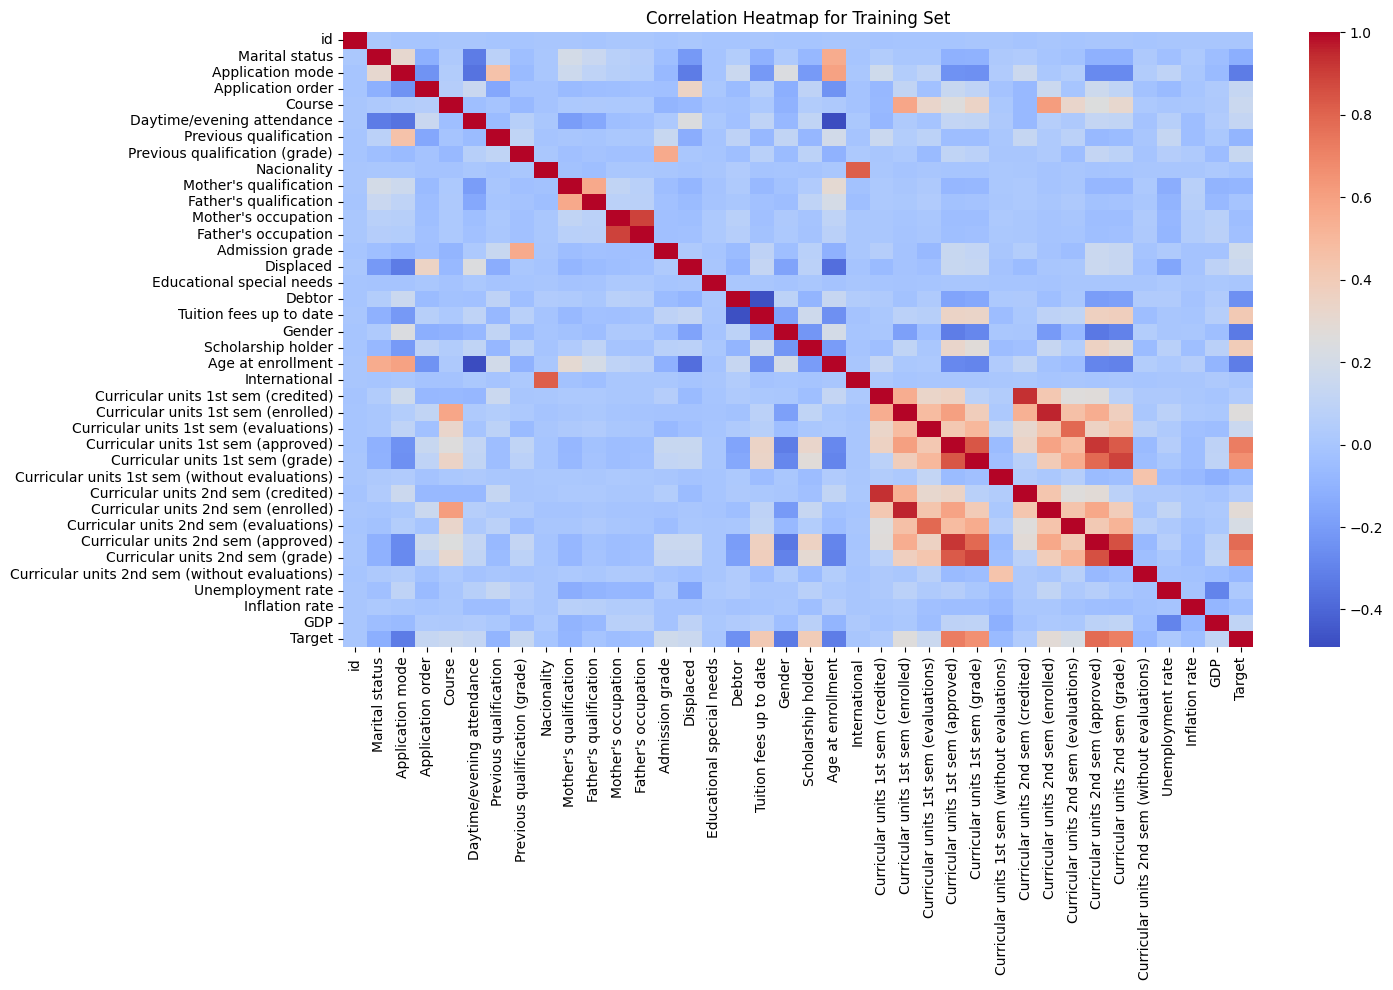

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))

correlation_matrix_train = df_train.corr(numeric_only=True)

sns.heatmap(correlation_matrix_train, cmap='coolwarm', ax=ax)

ax.set_title('Correlation Heatmap for Training Set')

# Display the plot
plt.tight_layout()
plt.show()

<p style="font-family: 'Meiryo UI'; font-size: 30px; padding: 12px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #007040;">🧪 Feature Engineering</p>

In [13]:
epsilon = 1e-10

for df in [df_train, df_test]:
    
    # Features V1 (This was the first new subset of features that I created)
    
    df['Total Curricular Units Enrolled'] = df['Curricular units 1st sem (enrolled)'] + df['Curricular units 2nd sem (enrolled)']
    df['Total Curricular Units Approved'] = df['Curricular units 1st sem (approved)'] + df['Curricular units 2nd sem (approved)']
    df['Total Curricular Units Evaluated'] = df['Curricular units 1st sem (evaluations)'] + df['Curricular units 2nd sem (evaluations)']
    df['Total Curricular Units Grade'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2

    df['Mother Higher Education'] = df['Mother\'s qualification'].apply(lambda x: 1 if x > 0.5 else 0)

    df['High Admission Grade'] = df['Admission grade'].apply(lambda x: 1 if x >= 0.5 else 0)
    
    # Features V2 (This was the second new subset of features that I created)
    df['Is Daytime Attendance'] = df['Daytime/evening attendance'].apply(lambda x: 1 if x == 1 else 0)
    df['High Previous Qualification Grade'] = df['Previous qualification (grade)'].apply(lambda x: 1 if x >= 0.5 else 0)
    df['Displacement Status'] = df['Displaced'].apply(lambda x: 1 if x == 1 else 0)
    df['Total Evaluations'] = df['Curricular units 1st sem (evaluations)'] + df['Curricular units 2nd sem (evaluations)']
    df['Total Approved'] = df['Curricular units 1st sem (approved)'] + df['Curricular units 2nd sem (approved)']
    df['Average Grade'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2

    df['Enrollment Ratio'] = df['Total Curricular Units Approved'] / (df['Total Curricular Units Enrolled'] + epsilon)
    df['Evaluation Ratio'] = df['Total Evaluations'] / (df['Total Curricular Units Enrolled'] + epsilon)
    df['Grade Improvement'] = df['Curricular units 2nd sem (grade)'] - df['Curricular units 1st sem (grade)']
    df['Qualification Level'] = df['Previous qualification'] + df['Mother\'s qualification']

<p style="font-family: 'Meiryo UI'; font-size: 30px; padding: 12px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #007040;">🔬 Feature Selection</p>

- I decided to apply Feature Selection strategies that do not use any Machine Learning model as basis.
- Since this dataset has two different types of data, our strategy is kinda simple: 

1. If the feature is categorical, we will apply the Chi Square test.
2. If the feature is numerical, we will apply the Pearson Correlation.

In [14]:
def chi_square_test(df, feature, target):
    contingency_table = pd.crosstab(df[feature], df[target])
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
    return chi2, p

def pearson_corr(df, feature, target):
    corr, p = stats.pearsonr(df[feature], df[target])
    return corr, p

def is_categorical(column):
    return isinstance(column.dtype, pd.CategoricalDtype) or pd.api.types.is_object_dtype(column) or pd.api.types.is_integer_dtype(column)

target_column = 'Target'

results = {}

for column in df_train.columns:
    
    if column != target_column:
        
        if is_categorical(df_train[column]):
            chi2, p = chi_square_test(df_train, column, target_column)
            results[column] = {'Test': 'Chi-square', 'Statistic': chi2, 'p-value': p}
            
        else:
            corr = df_train[column].corr(df_train['Target'])
            results[column] = {'Test': 'Pearson correlation', 'Statistic': np.abs(corr), 'p-value': None}

test_results = pd.DataFrame(results).T
test_results.head()

,Test,Statistic,p-value
id,Chi-square,153036.0,0.498077
Marital status,Chi-square,1728.622673,0.0
Application mode,Chi-square,13093.956509,0.0
Application order,Chi-square,2048.947784,0.0
Course,Chi-square,17313.816011,0.0


In [15]:
mi_features = list(test_results[(test_results['Test'] == "Chi-square") & (test_results['p-value'] < 0.05)].index)
pc_features = list(test_results[(test_results['Test'] == "Pearson correlation") & (test_results['Statistic'] >= 0.05)].index)

selected_features = ['Target']

selected_features.extend(mi_features)
selected_features.extend(pc_features)

print(f"Selected features: {len(selected_features)} out of {df_train.shape[1]}")

Selected features: 44 out of 54


In [16]:
df_train = df_train[selected_features]

selected_features.remove('Target')

df_test = df_test[selected_features]

<p style="font-family: 'Meiryo UI'; font-size: 30px; padding: 12px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #007040;">🦠 Outlier Detection</p>

- In previous experiments of this competition, I tested several methods to detect outliers. The method that provided the best results was based in a OneClassSVM.

In [17]:
X = df_train.drop(['Target'], axis= 1)
y = df_train['Target']

In [18]:
%%time

ocsvm_params = {
    "kernel" : 'rbf',
    "nu" : 0.1,
    "verbose" : False
}

ocsvm = OneClassSVM(**ocsvm_params)
outliers_ocsvm = ocsvm.fit_predict(X)

CPU times: total: 3min 4s
Wall time: 3min 30s


In [19]:
X_no_outliers = X[outliers_ocsvm == 1]
y_no_outliers = y[outliers_ocsvm == 1]

In [20]:
print(f"Total of {X.shape[0] - X_no_outliers.shape[0]} outliers detected by the OneClassSVM", end= "\n\n")
print(X.shape, X_no_outliers.shape)

Total of 7651 outliers detected by the OneClassSVM

(76518, 43) (68867, 43)


<p style="font-family: 'Meiryo UI'; font-size: 30px; padding: 12px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #007040;">📊 Data Preprocessing</p>

- We apply a standard normalization technique based on minimum and maximum values found in the dataset. Sometimes I do apply Gaussian Rank, however it does not work really well for this dataset.
- We split our dataset so we can validate our model later.

In [21]:
scaler = MinMaxScaler()
scaler.fit(X_no_outliers)

X_train_transformed = pd.DataFrame(scaler.transform(X_no_outliers), columns= X_no_outliers.columns)
X_test_transformed = pd.DataFrame(scaler.transform(df_test), columns= df_test.columns)

X_train_transformed.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Total Approved,Qualification Level,Previous qualification (grade),Admission grade,Curricular units 1st sem (grade),Curricular units 2nd sem (grade),GDP,Total Curricular Units Grade,Average Grade,Grade Improvement
0,0.0,0.000000,0.166667,0.665579,1.0,0.0,0.0,0.000000,0.418605,0.025773,...,0.279070,0.000000,0.326316,0.290526,0.768212,0.690476,0.803170,0.736411,0.736411,0.461698
1,0.0,0.307692,0.166667,0.665579,1.0,0.0,0.0,0.418605,0.418605,0.046392,...,0.093023,0.214286,0.315789,0.261053,0.614570,0.000000,0.803170,0.317223,0.317223,0.185507
2,0.0,0.307692,0.333333,0.674279,1.0,0.0,0.0,0.046512,0.418605,0.010309,...,0.000000,0.023810,0.442105,0.523158,0.000000,0.000000,0.414795,0.000000,0.000000,0.521739
3,0.0,0.000000,0.500000,0.808048,1.0,0.0,0.0,0.418605,0.046512,0.015464,...,0.325581,0.214286,0.378947,0.327368,0.667086,0.712222,0.803170,0.694917,0.694917,0.528370
4,0.0,0.000000,0.333333,0.808048,1.0,0.0,0.0,0.418605,0.837209,0.020619,...,0.279070,0.214286,0.389474,0.264211,0.685210,0.718519,0.578600,0.707371,0.707371,0.521739


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_transformed, 
    y_no_outliers,
    test_size= 0.25, 
    random_state= RANDOM_SEED, 
    stratify= y_no_outliers
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_test_transformed.shape)

(51650, 43) (51650,)
(17217, 43) (17217,)
(51012, 43)


<p style="font-family: 'Meiryo UI'; font-size: 30px; padding: 12px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #007040;">🤖 Modeling</p>

- Our modeling part will be based on 3 models:

    - XGBoost
    - LightGBM
    - CatBoost

- For each model, a objective function will be created. This function will be used by Optuna in order to optimize the hyperparameters.
- For each optimation process, we will use the Tree-Structured Parzen Estimator (TPE) sampler*
- We will combine the models before predicting the class labels.
- We evaluate our model based on Out-of-Fold Predictions

*Adding the TPE Sampler most likely will improve the performance of the optimization. In several cases, this method is reported increase the performance of the optimization process found in Optuna.

**Important**:

The optimization code cells take a while to run :)

This is why I will set the optimized set of parameters instead of running everything again, feel free to remove the comments to tune the hyperparameters with new settings!

In [23]:
def xgb_objective(trial):

    params = {
        'objective': 'multi:softmax',
        'num_class': len(targetEncoder.classes_),
        'eval_metric': 'mlogloss',
        
        'seed': SEED,
        'verbosity' : 0,

        'max_depth': trial.suggest_int('max_depth', 0, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),  
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),

        'gamma' : trial.suggest_float('gamma', 1e-9, 0.5),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0, log= True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),

        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    return acc

def lgbm_objective(trial):

    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        
        'num_class': len(targetEncoder.classes_),
        'verbosity': -1,
        'random_state': SEED, 

        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 1, 100),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000)
    }
    
    model = lgbm.LGBMClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    return acc

def catboost_objective(trial):

    params = {
        
        'loss_function': 'MultiClass',
        'eval_metric': 'MultiClass',
        'random_seed': SEED,
        'verbose': False,
 
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = cb.CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=False)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    return acc

In [24]:
# Create the TPE Sampler

sampler = optuna.samplers.TPESampler(
    n_startup_trials= 20,
    multivariate= True, 
    seed= RANDOM_SEED
)

C:\Users\mario\anaconda3\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


In [25]:
'''XGB optimization process.

xgb_study = optuna.create_study(
    sampler= sampler,
    direction= 'maximize'
)

xgb_study.optimize(
    xgb_objective, 
    n_trials= 100
)'''

'''Collecting XGB results

xgb_best_params = {
    
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',

    'num_class': len(targetEncoder.classes_),
    'verbosity': -1,
    'random_state': SEED, 
    
}

xgb_best_score = xgb_study.best_value
xgb_best_params.update(xgb_study.best_params)

print(json.dumps(xgb_best_params, indent= 4))
print(f"Score: {xgb_best_score}")
'''

xgb_best_params = {
    "objective": "multi:softmax",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "seed": 101,
    "verbosity": 0,
    "max_depth": 7,
    "min_child_weight": 3,
    "n_estimators": 900,
    "gamma": 0.398412184840652,
    "subsample": 0.9096019417191034,
    "reg_alpha": 6.296339358649067e-05,
    "reg_lambda": 6.33771421492116,
    "learning_rate": 0.01950645104250368,
    "colsample_bytree": 0.3620876943177316,
    "grow_policy": "depthwise"
}

In [26]:
'''LGBM Optimization process
study_lgbm = optuna.create_study(
    sampler= sampler,
    direction= 'maximize'
)

study_lgbm.optimize(
    lgbm_objective, 
    n_trials= 100
)'''

'''Collecting LGBM results

lgbm_best_params = {
    
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',

    'num_class': len(targetEncoder.classes_),
    'verbosity': -1,
    'random_state': SEED, 
}

lgbm_best_score = study_lgbm.best_value
lgbm_best_params.update(study_lgbm.best_params)

print(json.dumps(lgbm_best_params, indent= 4))
print(f"Score: {lgbm_best_score}")
'''

lgbm_best_params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 3,
    "verbosity": -1,
    "random_state": 101,
    "reg_alpha": 5.681148739666433e-07,
    "reg_lambda": 2.8013810555356244e-05,
    "colsample_bytree": 0.41227418745188,
    "subsample": 0.9228275425332874,
    "learning_rate": 0.01603071135653927,
    "max_depth": 8,
    "num_leaves": 193,
    "min_child_samples": 26,
    "min_data_per_group": 99,
    "n_estimators": 686
}

In [27]:
'''CatBoost optimization process

study_cat = optuna.create_study(
    sampler= sampler,
    direction= 'maximize'
)

study_cat.optimize(
    catboost_objective, 
    n_trials= 100
)'''


'''Collecting CatBoost results

cat_best_params = {
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass',
    'random_seed': SEED,
    'verbose': False,
}

cat_best_score = study_cat.best_value
cat_best_params.update(study_cat.best_params)

print(json.dumps(cat_best_params, indent= 4))
print(f"Score: {cat_best_score}")
'''

cat_best_params = {
    "loss_function": "MultiClass",
    "eval_metric": "MultiClass",
    "random_seed": 101,
    "verbose": False,
    "random_strength": 5.976753982203694e-05,
    "colsample_bylevel": 0.07263759800664622,
    "depth": 6,
    "boosting_type": "Plain",
    "bootstrap_type": "Bernoulli",
    "subsample": 0.9693787839173185
}

In [28]:
def oof_predictions(X_train, y_train, X_test, n_splits= 5):

    skf = StratifiedKFold(n_splits= n_splits, shuffle= True, random_state= RANDOM_SEED)
    
    oof_preds = np.zeros(X_train.shape[0])
    test_preds = np.zeros((X_test.shape[0], n_splits))

    for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X_train, y_train), total= n_splits, desc= 'SK-Fold')):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        voting_clf = VotingClassifier(
            estimators= [
                ("XGB", xgb.XGBClassifier(**xgb_best_params)),
                ("CB", cb.CatBoostClassifier(**cat_best_params)),
                ("LGBM", lgbm.LGBMClassifier(**lgbm_best_params))
            ],
            voting='soft'
        )

        voting_clf.fit(X_tr, y_tr)
        
        oof_preds[val_idx] = voting_clf.predict(X_val)
        test_preds[:, fold] = voting_clf.predict(X_test)

    oof_accuracy = accuracy_score(y_train, oof_preds)
    test_preds_mean = test_preds.mean(axis=1)

    return oof_preds, test_preds_mean, oof_accuracy

In [29]:
oof_preds, test_preds, oof_accuracy = oof_predictions(X_train.values, y_train.values, X_test.values)

SK-Fold: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.77s/it]


In [30]:
test_preds = np.array([int(i) for i in test_preds])

test_accuracy = accuracy_score(y_test.values, test_preds)

print(f"Validation Accuracy: {oof_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Validation Accuracy: 0.8339787028073572
Test Accuracy: 0.8362083986757275


#### Confusion Matrix

The model obtained the following performance across the different classes:

- 4298 out of 5138 Dropout (83.65%)
- 2148 out of 3433 Enrolled (61.56%)
- 7951 out of 8643 Graduate (91.99%)

Our model performs very well in classifying Graduates, but presents moderate performance for Dropouts and poor performance for Enrolled.

To improve the model's performance and, who knows, win the competition. We must focus on improvements related to the Enrolled class. I particularly don't like data augmentation in this scenario as we already have a lot of data compared to the total instances in the dataset, maybe I would focus more on feature engineerg.in

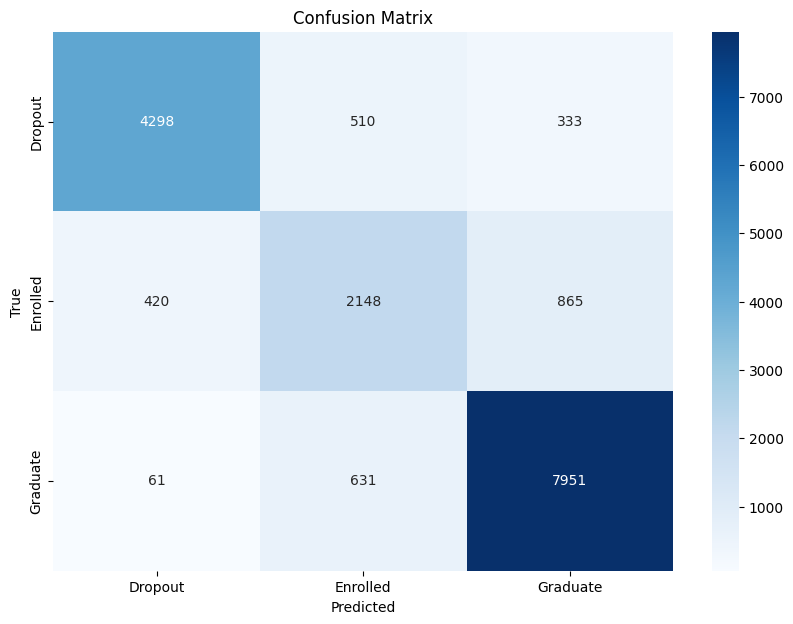

In [31]:
class_labels = targetEncoder.classes_

cm = confusion_matrix(y_test.values, test_preds)

plt.figure(figsize=(10, 7))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels= class_labels, yticklabels= class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
%%time

voting_clf = VotingClassifier(
    estimators= [
        ("XGB", xgb.XGBClassifier(**xgb_best_params)),
        ("CB", cb.CatBoostClassifier(**cat_best_params)),
        ("LGBM", lgbm.LGBMClassifier(**lgbm_best_params))
    ],
    voting='soft'
)

voting_clf.fit(X_train_transformed, y_no_outliers)

CPU times: total: 2min 44s
Wall time: 42.4 s


VotingClassifier(estimators=[('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3620876943177316,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None,
                                            gamma=0.398412184840652,
                                            grow_policy='depthwise',
                                            importance_type=None,...
                              LGBMClassifier(colsample_bytree=0.41227418745188,
                                             learning_rate=0.01603071135653927,
                                             max_depth=8,
                                             metric='multi_logloss',
                                             min_child_samples=26,
                                             min_data_per_group=99,
                                             n_estimators=686, num_class=3,
                                             num_leaves=193,
                                             objective='multiclass',
                                             random_state=101,
                                             reg_alpha=5.681148739666433e-07,
                                             reg_lambda=2.8013810555356244e-05,
                                             subsample=0.9228275425332874,
                                             verbosity=-1))],
                 voting='soft')

In [33]:
%%time

preds = voting_clf.predict(X_test_transformed)

CPU times: total: 18.6 s
Wall time: 3.1 s


<p style="font-family: 'Meiryo UI'; font-size: 30px; padding: 12px; text-align: center; color: #ffffff; border-radius: 15px;  font-weight: bold; background-color: #007040;">📩 Submission</p>

- We apply the inverse_transform to acquire the class labels for each prediction.
- This submission file provides a score of 0.83650 in the public leaderboard, similar to the result obtained by our private CV :D
- I had other approaches using AutoML frameworks: AutoGluon and MLJar, which were worst than this experiment.
- Blending the current solution with others achieve a score of 0.84+, which is currently a top 100 in the competition public leaderboard
- Also keep in mind that this might not be true for the private LB!

In [34]:
df_subm = pd.read_csv(PATH_SAMPLE)

df_subm['Target'] = targetEncoder.inverse_transform(preds)

df_subm.to_csv("Submission.csv", index= False)
df_subm.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
